In [39]:
import textblob
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import yfinance as yf
from datetime import datetime

In [27]:
path = "/Users/madha/Documents/GlobalAIHackathon/realdonaldtrump.csv"
df = pd.read_csv(path,encoding = 'utf-8')
df.head()

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [69]:
df.shape

(43352, 10)

In [68]:
#sentiment analysis
def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'


df["polarity"] = df["content"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["sentiment"] = df["content"].apply(lambda x: analyze_sentiment(x))
list(df)

['id',
 'link',
 'content',
 'date',
 'retweets',
 'favorites',
 'mentions',
 'hashtags',
 'polarity',
 'sentiment']

In [29]:
#data in date range
df['date'] = pd.to_datetime(df['date'])
start_date = '05-01-2020'
end_date = '07-01-2020'
mask = (df['date'] >= start_date) & (df['date'] < end_date)
df1 = df.loc[mask]
min(df1['date'])

2020-05-01 06:54:13


In [99]:
#group to single day
df1['date'] = pd.to_datetime(df1['date'])
df1['date'] = df1['date'].dt.date
groupeddf = df1.groupby('date',as_index=False)['polarity'].mean()
groupeddf['date'] = pd.to_datetime(groupeddf['date'])
groupeddf.tail()

<ipython-input-99-840fb9b9e43a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-99-840fb9b9e43a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,polarity
43,2020-06-13,0.218830
44,2020-06-14,-0.028570
45,2020-06-15,0.044573
46,2020-06-16,0.164154
47,2020-06-17,0.060417


In [93]:
#vizualization of tweet sentiment per day
fig = px.bar(groupeddf, x='date', y='polarity',title='overall twitter sentiment per day')
fig.show()

In [82]:
#import Stock data on same date range as tweet data
tkrdf = yf.download('NDAQ','2020-5-1','2020-6-17')
tkrdf = tkrdf.reset_index(level=0)
tkrdf.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-01,107.000000,107.540001,105.830002,106.620003,106.184677,730700
1,2020-05-04,105.809998,106.629997,104.379997,106.129997,105.696671,722700
2,2020-05-05,107.540001,109.480003,105.940002,108.830002,108.385651,966500
3,2020-05-06,109.769997,109.769997,105.599998,105.629997,105.198715,710200
4,2020-05-07,106.750000,109.220001,106.449997,107.330002,106.891777,633600


In [83]:
tkrdf.shape

(32, 7)

In [86]:
#summarize momentum on each day
tkrdf['diff'] = 0.00
prev = tkrdf['Close'][0]
for index,row in tkrdf.iterrows():
    tkrdf._set_value(index,'diff',row['Close']-prev)     
    prev=row['Close']
tkrdf.head()  

,Date,Open,High,Low,Close,Adj Close,Volume,diff
0,2020-05-01,107.000000,107.540001,105.830002,106.620003,106.184677,730700,0.000000
1,2020-05-04,105.809998,106.629997,104.379997,106.129997,105.696671,722700,-0.490005
2,2020-05-05,107.540001,109.480003,105.940002,108.830002,108.385651,966500,2.700005
3,2020-05-06,109.769997,109.769997,105.599998,105.629997,105.198715,710200,-3.200005
4,2020-05-07,106.750000,109.220001,106.449997,107.330002,106.891777,633600,1.700005


In [92]:
#vizualize stock momentum per day
fig = px.bar(tkrdf, x='Date', y='diff',title='Nasdaq stock price diff')
fig.show()


In [104]:
#Combine tweet and stock data
mergedf = pd.merge(tkrdf, groupeddf.rename(columns={'date':'Date'}), on='Date', how='inner')
mergedf.head()

,Date,Open,High,Low,Close,Adj Close,Volume,diff,polarity
0,2020-05-01,107.000000,107.540001,105.830002,106.620003,106.184677,730700,0.000000,0.053712
1,2020-05-04,105.809998,106.629997,104.379997,106.129997,105.696671,722700,-0.490005,0.105811
2,2020-05-05,107.540001,109.480003,105.940002,108.830002,108.385651,966500,2.700005,0.226685
3,2020-05-06,109.769997,109.769997,105.599998,105.629997,105.198715,710200,-3.200005,0.080191
4,2020-05-07,106.750000,109.220001,106.449997,107.330002,106.891777,633600,1.700005,-0.156818


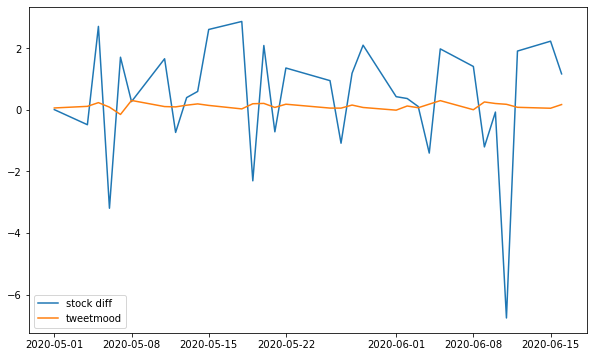

In [114]:
plt.figure(=(10, 6))
plt.plot(mergedf['Date'],mergedf['diff'],label='stock diff')
plt.plot(mergedf['Date'],mergedf['polarity'],label='tweetmood')
plt.legend(loc='best')
plt.show()

In [116]:
mergedf.to_csv ("/Users/madha/Documents/GlobalAIHackathon/mergedf.csv", index = False, header=True)
